In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

In [3]:
train_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training'
test_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Test'

IMG_HEIGHT = 40
IMG_WIDTH = 40
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(train_dir))

In [4]:
#Only used for experiment 4
class_counts = Counter([folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))])
class_labels = list(class_counts.keys())
num_classes = len(class_labels)

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


Found 70491 images belonging to 141 classes.


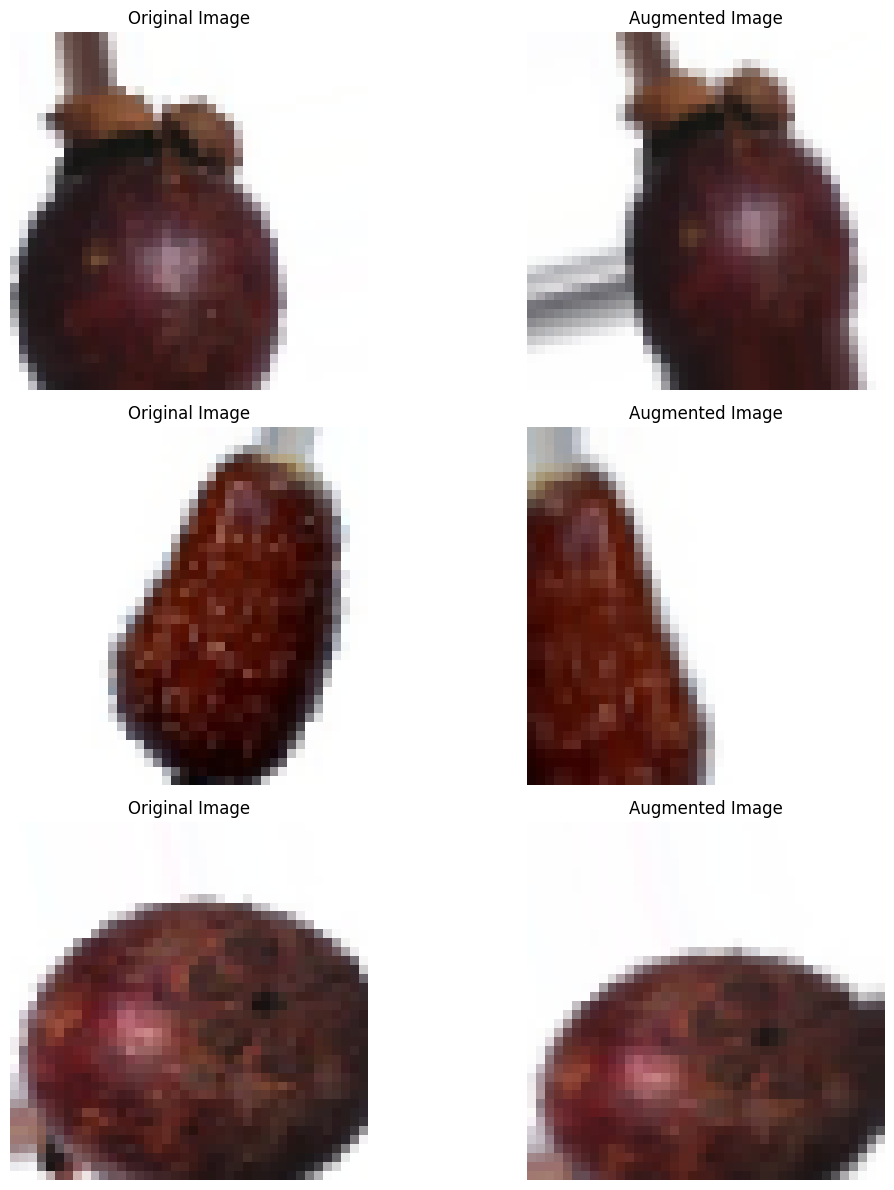

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_original_vs_augmented(datagen, directory, num_images=3):
    generator = datagen.flow_from_directory(
        directory,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=1, 
        class_mode='categorical'
    )

    plt.figure(figsize=(12, num_images * 4))

    for i in range(num_images):
        img, label = next(generator)
        original_image = img[0]
        augmented_image = datagen.random_transform(original_image)

        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis('off')

        
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(augmented_image)
        plt.title("Augmented Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_original_vs_augmented(train_datagen, train_dir)


In [6]:
#Only used for experiment 4
import numpy as np
labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.0569475057352347, 1: 1.0161304272617193, 2: 1.1259823653440675, 3: 1.0415336879432624, 4: 1.0161304272617193, 5: 1.0393683372406777, 6: 1.0161304272617193, 7: 1.096351250466592, 8: 1.0161304272617193, 9: 1.0161304272617193, 10: 1.1653523781183355, 11: 1.0202778983934, 12: 1.0161304272617193, 13: 0.7439526342451874, 14: 0.7121597866278717, 15: 1.0161304272617193, 16: 1.1708107030743933, 17: 1.0181999393335355, 18: 1.0202778983934, 19: 1.11096926713948, 20: 1.0202778983934, 21: 1.11096926713948, 22: 1.0821129225384545, 23: 3.471778959810875, 24: 1.0202778983934, 25: 1.0161304272617193, 26: 1.0161304272617193, 27: 1.0202778983934, 28: 3.3108355643229532, 29: 0.7121597866278717, 30: 1.0161304272617193, 31: 0.6774202848411462, 32: 0.6774202848411462, 33: 1.0161304272617193, 34: 1.0161304272617193, 35: 1.0161304272617193, 36: 1.11096926713948, 37: 1.0202778983934, 38: 1.0202778983934, 39: 1.11096926713948, 40: 1.0821129225384545, 41: 3.3329078014184397, 42: 2.04891873038

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.008), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator)

#for experiment 4, just have to add an additional parameter 'class_weights=class_weights_dict' in model.fit()

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733868478.117869     115 service.cc:145] XLA service 0x7d3498003cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733868478.117933     115 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733868478.117940     115 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/2203 ━━━━━━━━━━━━━━━━━━━━ 6:05:59 10s/step - accuracy: 0.0000e+00 - loss: 5.6551

I0000 00:00:1733868482.968455     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2203/2203 ━━━━━━━━━━━━━━━━━━━━ 798s 358ms/step - accuracy: 0.1472 - loss: 3.3789 - val_accuracy: 0.4402 - val_loss: 1.6957
Epoch 2/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 162s 73ms/step - accuracy: 0.3008 - loss: 2.3082 - val_accuracy: 0.4811 - val_loss: 1.7746
Epoch 3/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 184s 83ms/step - accuracy: 0.3594 - loss: 2.0859 - val_accuracy: 0.5797 - val_loss: 1.2660
Epoch 4/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 155s 70ms/step - accuracy: 0.3871 - loss: 1.9879 - val_accuracy: 0.6327 - val_loss: 1.1958
Epoch 5/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 145s 66ms/step - accuracy: 0.4118 - loss: 1.9044 - val_accuracy: 0.6466 - val_loss: 1.1315
Epoch 6/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 150s 68ms/step - accuracy: 0.4208 - loss: 1.8633 - val_accuracy: 0.6474 - val_loss: 1.0320
Epoch 7/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 164s 74ms/step - accuracy: 0.4347 - loss: 1.8141 - val_accuracy: 0.7688 - val_loss: 0.7257
Epoch 8/25
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 150s 68ms/step - accuracy: 0.4465 - l

In [10]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

739/739 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.7988 - loss: 0.7177
Test Accuracy: 80.04%


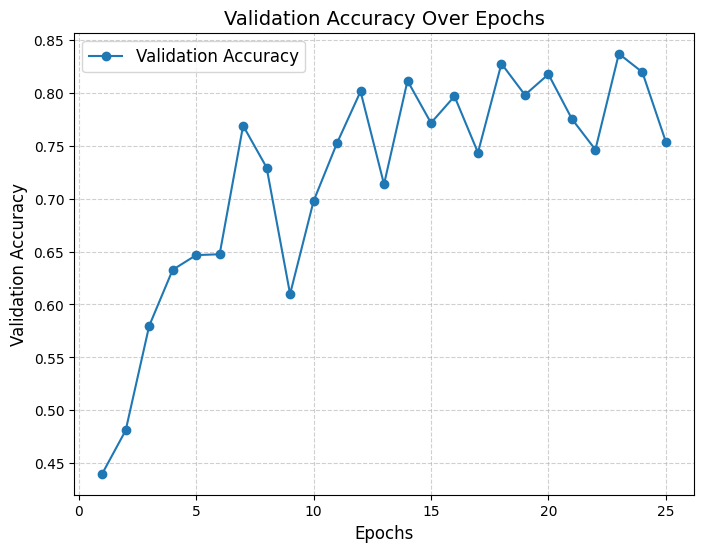

In [7]:
import matplotlib.pyplot as plt

val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()